In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import pprint
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import json
import models
from plot_configs import plot_configs

In [2]:
''' choose the transformer architecture hyperparameters  '''
model_str = 'gpt3_1T'  # what model? choose from models.py (gpt3_1T, vit_era5) 
model = models.models[model_str]
# set model hyperparams
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print('model is {}'.format(model))

'''set some dataset size hyperparameters 
   if LLMs, it's number of tokens, else
   it's number of samples in ERA5.     '''

if model_str == 'gpt3_1T':
    total_tokens = 1 * 10**12
else:
    total_tokens = 300 * 10**9
    
num_samples = total_tokens / l
if 'vit_era5' in model_str:
    num_ep = 80
    num_samples = 350000 * num_ep
print('training on {} samples'.format(num_samples))
global_batch_size = 4096

model is {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128, 'f': 102400}
training on 488281250.0 samples


In [3]:
''' sweep through different systems with different GPUs and different NVS sizes '''
systems = ['A100-NVS4', 'A100-NVS8', 'A100-NVS64', 'H200-NVS4', 'H200-NVS8', 'H200-NVS64', 'B200-NVS4', 'B200-NVS8', 'B200-NVS64']
config_names = ['A100', 'A100', 'A100', 'H200', 'H200', 'H200', 'B200', 'B200', 'B200']
nvlink_sizes = [4, 8, 64, 4, 8, 64, 4, 8, 64] # nvs sizes
parallel_strat = '1d' # '2d' for summa and '2d-seqp' for context

at 4096 gpus, time = 97.95589402067628
---------------
base performance taken at A100-NVS4,512
at 4096 gpus, time = 86.8807023609844
---------------
at 4096 gpus, time = 85.21805188205126
---------------
at 4096 gpus, time = 30.950515330805572
---------------
at 4096 gpus, time = 30.145875710438375
---------------
at 4096 gpus, time = 28.791395834540086
---------------
at 4096 gpus, time = 12.883226747728267
---------------
at 4096 gpus, time = 12.471512525793573
---------------
at 4096 gpus, time = 12.080721097452873
---------------


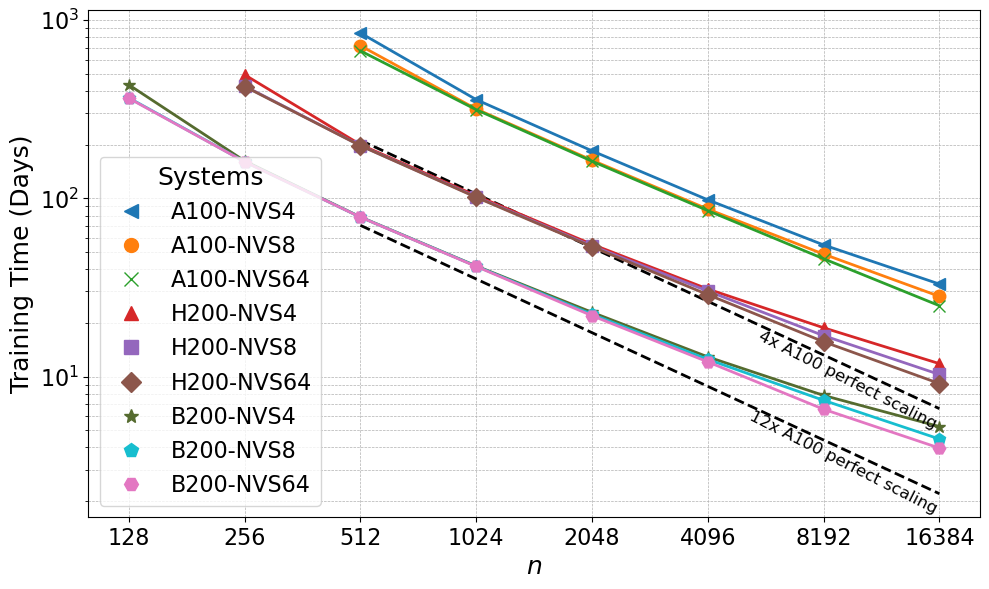

In [4]:
''' plot the total training time as a function of #GPUs for different systems '''

styles = ['<', 'o', 'x', '^', 's', 'D', '*', 'p', 'H', 'v', 'P']
st_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#556b2f', '#17becf', '#e377c2', '#7f7f7f', '#bcbd22']

fig, axs = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)
axs.tick_params(axis='both', which='major', labelsize=16)
axs.tick_params(axis='both', which='minor', labelsize=16)

sys_str_handles = []
gpu_count_to_read = 4096  # just print the times at this #gpus to check
feasible = False

for st, sys_str in enumerate(systems):
    x = np.load('../outputs/exec_{}_{}_{}.npy'.format(parallel_strat, model_str, sys_str), allow_pickle=True)
    nvc = 0
    for nvs, t_max, t_min, n_gpus, configs in x:
        if len(t_max) == 0:
            continue
        feasible = True
        time = [(num_samples / tm) / (3600 * 24) for tm in t_max]
        
        pidx = list(n_gpus).index(gpu_count_to_read)
        print("at {} gpus, time = {}\n---------------".format(n_gpus[pidx], time[pidx]))
        line, = axs.plot(n_gpus, time, label=f'nv = {nvs}', marker=styles[st], markersize=9, color=st_colors[st], linewidth=2)
        
        if sys_str == 'A100-NVS4':
            print('base performance taken at {},{}'.format(sys_str, n_gpus[0]))
            x_start = n_gpus[0]
            x_end = n_gpus[-1]
            fac = x_end / x_start
            y_start = time[0]/4
            y_end = time[0]/(4 * fac)
            # perfect scaling at 4X
            axs.plot([x_start, x_end], [y_start, y_end], linestyle='--', linewidth=2, color='k')
            axs.annotate('4x A100 perfect scaling', xy=(x_end, y_end), xytext=(0, 58),
                         textcoords="offset points", fontsize=12, verticalalignment='top', horizontalalignment='right', rotation=-27)
            
            y_start = time[0]/12
            y_end = time[0]/(12 * fac)
            # perfect scaling at 4X
            axs.plot([x_start, x_end], [y_start, y_end], linestyle='--', linewidth=2, color='k')
            axs.annotate('12x A100 perfect scaling', xy=(x_end, y_end), xytext=(0, 61),
                         textcoords="offset points", fontsize=12, verticalalignment='top', horizontalalignment='right', rotation=-27)

        axs.set_yscale('log', base=10)
        axs.set_xscale('log', base=2)
        axs.set_xticks(n_gpus)
        axs.set_xticklabels(n_gpus)
        axs.set_xlabel(r'$n$', fontsize=18)
        axs.set_ylabel('Training Time (Days)', fontsize=18)
        nvc += 1
    sys_str_handles.append(Line2D([0], [0], marker=styles[st], color=st_colors[st], label=sys_str, linestyle='None', markersize=10))

if not feasible:
    print('No feasible configs!')
# Add legends
sys_str_legend = axs.legend(handles=sys_str_handles, title="Systems", fontsize=16, loc='lower left', title_fontsize=18)
axs.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()
plt.show()
# plt.savefig('../outputs/exec_{}_{}.pdf'.format(parallel_strat, model_str), dpi=400)

base performance taken at A100-NVS4,512


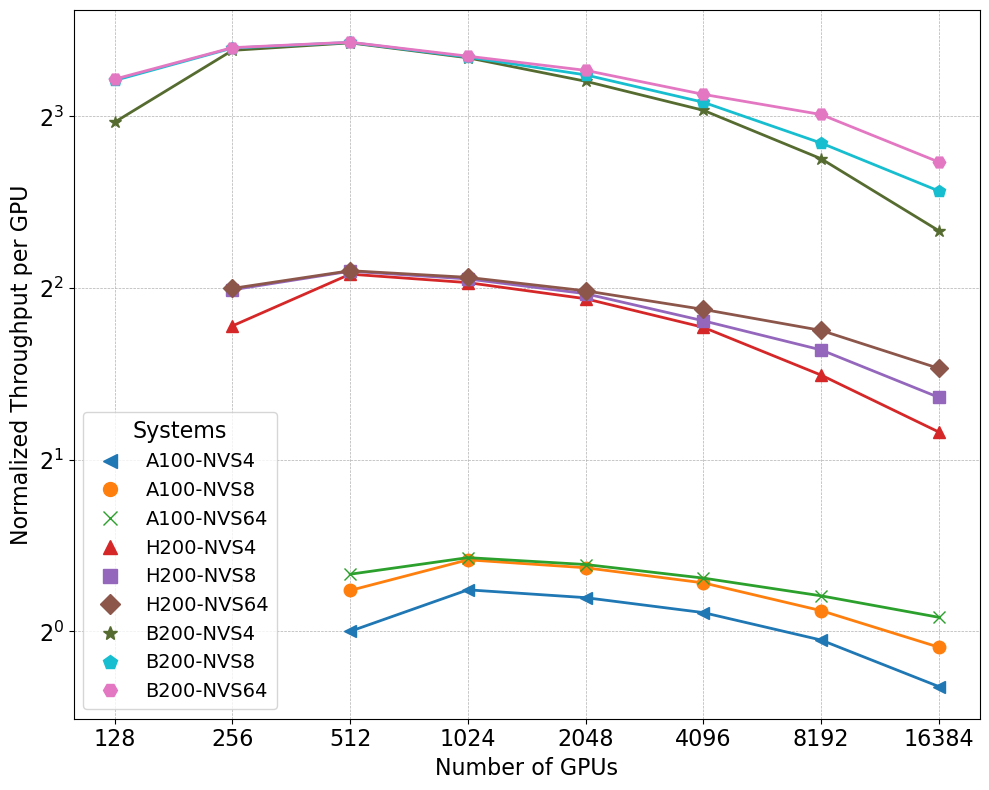

In [5]:
''' plot the throughput per GPU as a function of #GPUs for different systems. 
    This allows NVLINK/NVS effects to be amplified  '''

styles = ['<', 'o', 'x', '^', 's', 'D', '*', 'p', 'H', 'v', 'P']
st_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#556b2f', '#17becf', '#e377c2', '#7f7f7f', '#bcbd22']

fig, axs = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
axs.tick_params(axis='both', which='major', labelsize=16)
axs.tick_params(axis='both', which='minor', labelsize=16)
sys_str_handles = []

gpu_count_to_read = 2048
feasible = False
for st, sys_str in enumerate(systems):
    x = np.load('../outputs/exec_{}_{}_{}.npy'.format(parallel_strat, model_str, sys_str), allow_pickle=True)
    nvc = 0
    for nvs, t_max, t_min, n_gpus, configs in x:
        if len(t_max) == 0:
            continue
        feasible = True
        if sys_str == 'A100-NVS4':
            print('base performance taken at {},{}'.format(sys_str, n_gpus[0]))
            perf_base = (t_max[0] / n_gpus[0])
            # perf_base = 1 / ((num_samples / t_max[0]) / (3600 * 24)) / n_gpus[0]
        perf = [(tm / ng) / perf_base for tm, ng in zip(t_max, n_gpus)]
        line, = axs.plot(n_gpus, perf, label=f'nv = {nvs}', marker=styles[st], markersize=9, color=st_colors[st], linewidth=2)
        axs.set_yscale('log', base=2)
        axs.set_xscale('log', base=2)
        axs.set_xticks(n_gpus)
        axs.set_xticklabels(n_gpus)
        axs.set_xlabel('Number of GPUs', fontsize=16)
        axs.set_ylabel('Normalized Throughput per GPU', fontsize=16)
        nvc += 1
    sys_str_handles.append(Line2D([0], [0], marker=styles[st], color=st_colors[st], label=sys_str, linestyle='None', markersize=10))

if not feasible:
    print('No feasible configs!')
# Add legends
sys_str_legend = axs.legend(handles=sys_str_handles, title="Systems", fontsize=14, loc='lower left', title_fontsize=16)
axs.grid(True, which='both', linestyle='--', linewidth=0.5)

fig.tight_layout()
# plt.savefig('../outputs/exec_perf_{}_{}.pdf'.format(parallel_strat,model_str), dpi=400)

TP:  [8 4 2 2 4 4 8 8]
PP:  [ 16  64 128 128 128 128  64  64]
PP:  [ 1  1  2  4  4  8 16 32]
MBS:  [4096 4096 2048 1024 1024  512  256  128]
Mem:  [182.91392512 150.20376064 183.11467008 169.35139328  98.09789184
  94.65693824  62.71694272  61.85663712]
TP in NVLINK:  [8 4 2 2 4 4 8 8]
DP in NVLINK:  [1 1 2 2 1 1 1 1]
PP in NVLINK:  [1 2 2 2 2 2 1 1]


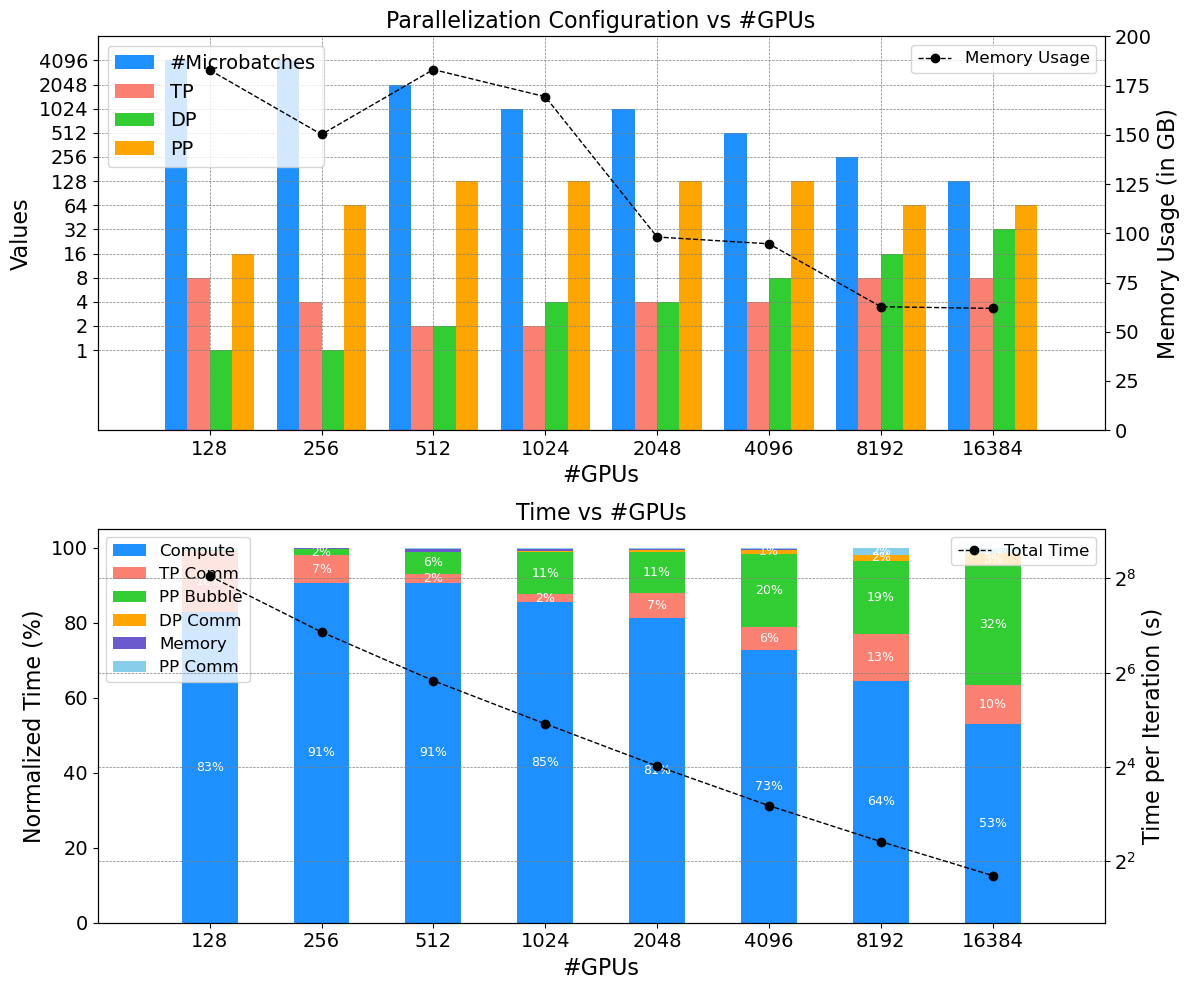

In [6]:
''' plot the optimal parallelization configuration 
as well as training time decomposed into its various 
components (compute, mem, comms, bubbles) as a function
of #GPUs for any system '''

import matplotlib.pyplot as plt
import numpy as np

sys_str = 'B200-NVS8'
x = np.load('../outputs/exec_{}_{}_{}.npy'.format(parallel_strat, model_str, sys_str), allow_pickle=True)
for nvs, t_max, t_min, n_gpus, configs in x:
    break
    
if all(not c for c in configs):
    assert False, 'no feasible configs!'
        
n_values = n_gpus
m_values =  np.array([(global_batch_size/c[0][2]['dp'])/c[0][2]['mbs'] for c in configs]).astype(int)
    
if parallel_strat == '1d':
    tp_values = np.array([c[0][2]['tp'] for c in configs])
    nv1_values = np.array([c[0][3]['nv_tp'] for c in configs])
else:
    # 2D tensor parallel
    tp1_values = np.array([c[0][2]['tp1'] for c in configs])
    tp2_values = np.array([c[0][2]['tp2'] for c in configs])
    tp_values = tp1_values * tp2_values
    nv1_1_values = np.array([c[0][3]['nv_tp1'] for c in configs])
    nv1_2_values = np.array([c[0][3]['nv_tp2'] for c in configs])
    if parallel_strat == '2d':
        nb_values = np.array([c[0][2]['nb'] for c in configs])
nv2_values = np.array([c[0][3]['nv_dp'] for c in configs])
nv3_values = np.array([c[0][3]['nv_pp'] for c in configs])
pp_values = np.array([c[0][2]['pp'] for c in configs])
dp_values = np.array([c[0][2]['dp'] for c in configs])
mem_values = np.array([c[0][3]['mem'] for c in configs])

print('TP: ', tp_values)
print('PP: ', pp_values)
print('PP: ', dp_values)
print('MBS: ', m_values)
print('Mem: ', mem_values)

if parallel_strat == '1d':
    print('TP in NVLINK: ', nv1_values) 
else:
    print('TP1 in NVLINK: ', nv1_1_values) 
    print('TP2 in NVLINK: ', nv1_2_values)
    if parallel_strat == '2d':
        print('SUMMA nb (#outer prods): ', nb_values)
print('DP in NVLINK: ', nv2_values) # number of GPUs in a node belonging to data parallel grp on NVLINK
print('PP in NVLINK: ', nv3_values)

time_part1 = np.array([c[0][3]['t_comp'] for c in configs])
time_part2 = np.array([c[0][3]['t_tp_comm'] for c in configs])
time_part3 = np.array([c[0][3]['t_bubble'] for c in configs])
time_part4 = np.array([c[0][3]['t_dp_comm'] for c in configs])
time_part5 = np.array([c[0][3]['t_mem'] for c in configs])
time_part6 = np.array([c[0][3]['t_pp_comm'] for c in configs])
time_total = time_part1 + time_part2 + time_part3 + time_part4 + time_part5 + time_part6
# normalize the time parts
time_parts = np.array([time_part1, time_part2, time_part3, time_part4, time_part5, time_part6])
time_parts_normalized = time_parts / time_total[:, np.newaxis].T * 100

if parallel_strat == '1d':
    plot_configs(n_values, time_total, time_parts_normalized, 
                 mem_values, m_values, tp_values, dp_values, pp_values)
else:
    plot_configs(n_values, time_total, time_parts_normalized, 
                 mem_values, m_values, tp_values, dp_values, pp_values, tp1_values, tp2_values)